C:\AI\Mamografie\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\AI\Mamografie\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🎯 Etichete reale: Counter({np.int64(0): 88, np.int64(1): 31})
📊 Predicții: Counter({np.int64(0): 97, np.int64(1): 22})

Raport clasificare:
              precision    recall  f1-score   support

      Benign       0.84      0.92      0.88        88
      Malign       0.68      0.48      0.57        31

    accuracy                           0.81       119
   macro avg       0.76      0.70      0.72       119
weighted avg       0.80      0.81      0.80       119


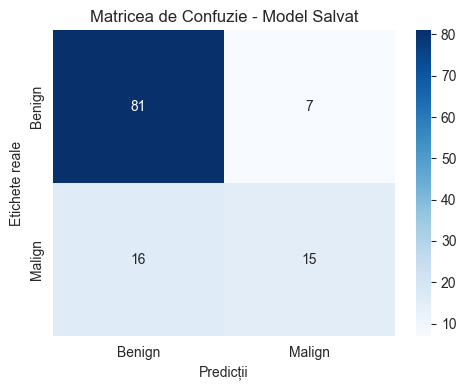

In [1]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ------------------ Config ------------------
val_dir = "validare"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ Transformari ------------------
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ------------------ Încarcă modelul ------------------
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # trebuie să fie exact ca în codul tău
model.load_state_dict(torch.load("resnet50_mamografie_best_now/model.pt", map_location=device))
model.to(device)
model.eval()

# ------------------ Predictii ------------------
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ------------------ Matrice de Confuzie ------------------
cm = confusion_matrix(y_true, y_pred)
print("🎯 Etichete reale:", Counter(y_true))
print("📊 Predicții:", Counter(y_pred))
print("\nRaport clasificare:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malign"]))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malign"],
            yticklabels=["Benign", "Malign"])
plt.xlabel("Predicții")
plt.ylabel("Etichete reale")
plt.title("Matricea de Confuzie - Model Salvat")
plt.tight_layout()

# Salvează imaginea
os.makedirs("confusion_matrices", exist_ok=True)
plt.savefig("confusion_matrices/conf_matrix_final_model_salvat.png")
plt.show()
